In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from datetime import datetime


from utils import concat_dfs, substituir_cod_municipio


In [66]:
data_type = "files"  # files ou api

auxilio_emergencial = concat_dfs(
    f"parsed_data/auxilio_emergencial/{data_type}"
)

bolsa_familia = concat_dfs(f"parsed_data/bolsa_familia/{data_type}")

suicidios = pd.read_csv("parsed_data/suicidios/suicidios.csv")
suicidios["date"] = pd.to_datetime(suicidios["date"])
suicidios["municipio_ibge"] = suicidios["municipio_ibge"].astype(float)

populacao = pd.read_csv("parsed_data/municipios/populacao.csv")


In [67]:
bolsa_familia = substituir_cod_municipio(bolsa_familia)


In [68]:
auxilio_emergencial = auxilio_emergencial[
    auxilio_emergencial["municipio_ibge"].notna()
]
auxilio_emergencial["municipio_ibge"] = auxilio_emergencial[
    "municipio_ibge"
].astype(int)
suicidios["municipio_ibge"] = suicidios["municipio_ibge"].astype(int)


In [69]:
df_all = pd.merge(
    bolsa_familia,
    auxilio_emergencial,
    on=["municipio_ibge", "date"],
    how="outer",
)


In [70]:
df_all = pd.merge(
    df_all, suicidios, on=["municipio_ibge", "date"], how="outer"
)


In [71]:
df_all["year"] = df_all["date"].dt.year


In [72]:
df_all = df_all[df_all["municipio_ibge"] != 0]


In [73]:
def remove_last_digit(x):
    if len(str(x)) == 7:
        return int(str(x)[:-1])
    else:
        return int(str(x))


df_all["municipio_ibge6"] = df_all["municipio_ibge"].apply(
    lambda x: remove_last_digit(x)
)


In [74]:
df_all = pd.merge(
    df_all, populacao, on=["municipio_ibge6", "year"], how="outer"
)


In [75]:
# ordering columns
columns = [
    "municipio_ibge",
    "contagem_x",
    "soma_x",
    "date",
    "soma_y",
    "contagem_y",
    "suicidios",
    "obitos_totais",
    "taxa_suicidio",
    "year",
    "municipio_ibge6",
    'populacao',
    'nome'
]
df_all = df_all[columns]


In [76]:
df_all.columns = [
    "municipio_ibge",
    "beneficiarios_bolsa_familia",
    "valor_bolsa_familia",
    "date",
    "valor_auxilio_emergencial",
    "beneficiarios_auxilio_emergencial",
    "suicidios",
    "obitos_totais",
    "taxa_suicidio",
    "ano",
    "municipio_ibge6",
    "populacao",
    "nome_municipio",
]


In [77]:
date_mask = (df_all["date"] >= "2019-08") & (df_all["date"] <= "2020-12")
df_all = df_all[date_mask]


In [78]:
df_all["valor_bolsa_familia"] = df_all["valor_bolsa_familia"].fillna(0)
df_all["valor_auxilio_emergencial"] = df_all[
    "valor_auxilio_emergencial"
].fillna(0)
df_all["beneficiarios_bolsa_familia"] = df_all[
    "beneficiarios_bolsa_familia"
].fillna(0)
df_all["beneficiarios_auxilio_emergencial"] = df_all[
    "beneficiarios_auxilio_emergencial"
].fillna(0)


In [79]:
# Dropando municipios sem dados de populacao (37 linhas)
df_all.dropna(subset="populacao", inplace=True)


In [80]:
# preenchendo dados faltantes de obitos e suicidios (assume-se que são 0 nessas datas)
df_all["obitos_totais"].fillna(0, inplace=True)
df_all["suicidios"].fillna(0, inplace=True)
df_all["taxa_suicidio"].fillna(0, inplace=True)


In [81]:
df_all.isna().sum()


municipio_ibge                       0
beneficiarios_bolsa_familia          0
valor_bolsa_familia                  0
date                                 0
valor_auxilio_emergencial            0
beneficiarios_auxilio_emergencial    0
suicidios                            0
obitos_totais                        0
taxa_suicidio                        0
ano                                  0
municipio_ibge6                      0
populacao                            0
nome_municipio                       0
dtype: int64

In [82]:
df_all["valor_total"] = (
    df_all["valor_bolsa_familia"] + df_all["valor_auxilio_emergencial"]
)


In [83]:
df_all["valor_medio"] = df_all["valor_total"] / (
    df_all["beneficiarios_auxilio_emergencial"]
    + df_all["beneficiarios_bolsa_familia"]
)


In [84]:
df_all["cobertura_ae"] = (
    df_all["beneficiarios_auxilio_emergencial"] / df_all["populacao"]
)
df_all["cobertura_bf"] = (
    df_all["beneficiarios_bolsa_familia"] / df_all["populacao"]
)


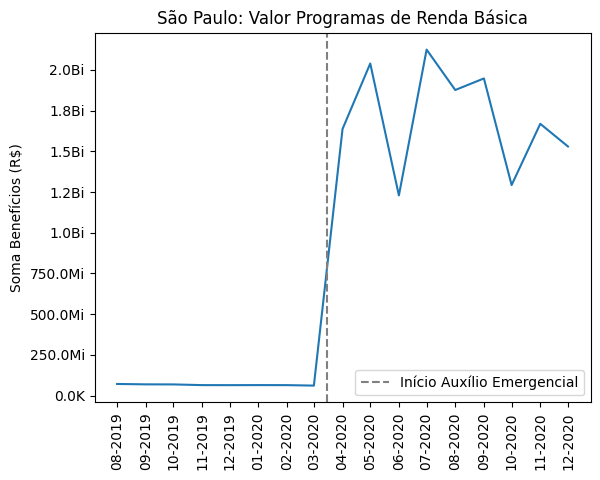

In [85]:
def format_number(data_value, indx):
    if data_value >= 1_000_000_000:
        formatter = "{:1.1f}Bi".format(data_value*0.000_000_001)
    elif data_value >= 1_000_000:
        formatter = "{:1.1f}Mi".format(data_value*0.000_001)
    else:
        formatter = "{:1.1f}K".format(data_value*0.001)
    return formatter

data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="valor_total")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
ax.yaxis.set_major_formatter(format_number)
plt.yticks(np.arange(0, max(data['valor_total']), 250_000_000))
plt.xticks(rotation=90)
plt.ylabel('Soma Benefícios (R$)')
plt.xlabel('')
plt.axvline(datetime(2020, 3,15), linestyle='dashed', label='Início Auxílio Emergencial', color='grey')
plt.title("São Paulo: Valor Programas de Renda Básica")
plt.legend()
plt.show()


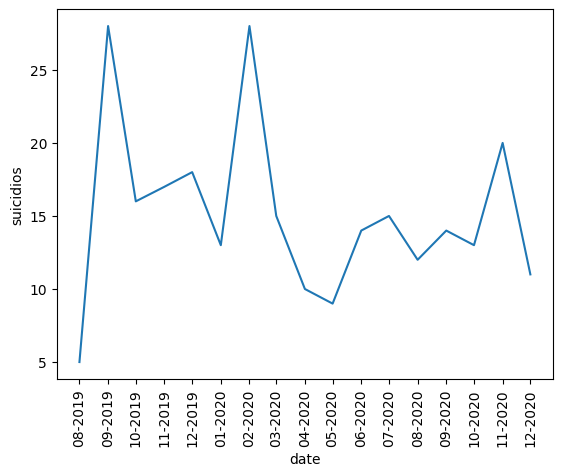

In [86]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="suicidios")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
plt.xticks(rotation=90)
plt.show()


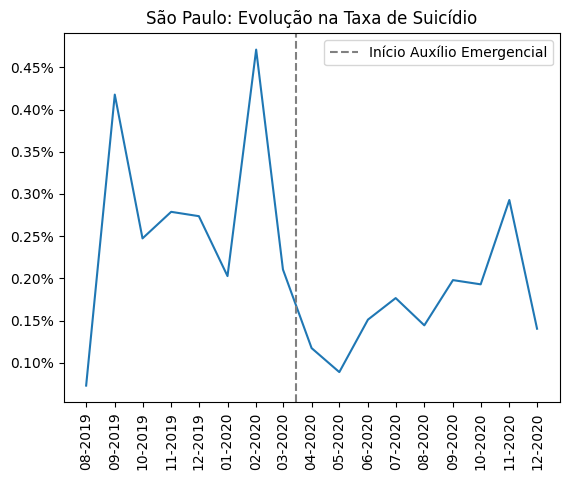

In [87]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="taxa_suicidio")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
ax.yaxis.set_major_formatter(lambda x, y: '{:,.2f}%'.format(x*100))
plt.xticks(rotation=90)
plt.yticks(np.arange(0.001, max(data['taxa_suicidio']), 0.0005))
plt.ylabel('')
plt.xlabel('')
plt.axvline(datetime(2020, 3,15), linestyle='dashed', label='Início Auxílio Emergencial', color='grey')
plt.title("São Paulo: Evolução na Taxa de Suicídio")
plt.legend()
plt.show()


0.0008175065155539198
-0.001060045801526353


<AxesSubplot: xlabel='delta_suicidio', ylabel='percentil'>

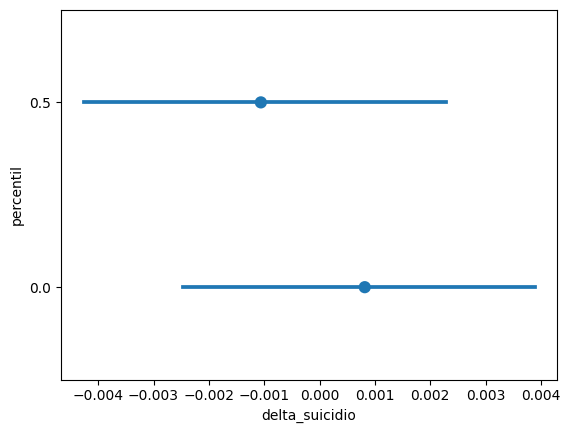

In [88]:
df_202003 = df_all[df_all["date"] == "2020-03-01"]
df_202004 = df_all[df_all["date"] == "2020-04-01"]

colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_suicidio"]

df_202003_rel = df_202003[colunas_relevantes]
df_202004_rel = df_202004[colunas_relevantes]

# df_202003_202004 = pd.merge(df_202003_rel, df_202004_rel)
df_202003_202004 = pd.merge(
    df_202003_rel, df_202004_rel, on=["municipio_ibge"]
)
df_202003_202004["variacao"] = (
    df_202003_202004["valor_medio_y"] - df_202003_202004["valor_medio_x"]
)

divisao = 2
df_divisions = np.array_split(
    df_202003_202004.sort_values("variacao"), divisao
)
for i, dfs_division in enumerate(df_divisions):
    indices = dfs_division.index
    df_202003_202004.loc[indices, "percentil"] = i / divisao

df_202003_202004["delta_suicidio"] = (
    df_202003_202004["taxa_suicidio_y"] - df_202003_202004["taxa_suicidio_x"]
)

for i, df_percentil in enumerate(df_divisions):
    print(
        df_percentil["taxa_suicidio_y"].mean()
        - df_percentil["taxa_suicidio_x"].mean()
    )

sns.pointplot(
    data=df_202003_202004,
    x="delta_suicidio",
    y="percentil",
    join=False,
    orient="h",
    order=-np.sort(-df_202003_202004["percentil"].unique()),
)


2020-03-01 00:00:00
2020-04-01 00:00:00
0.0013805282156996428
0.001014111687419916
-0.0026475176888950108
0.0017099944656960835
-0.002063464894851704


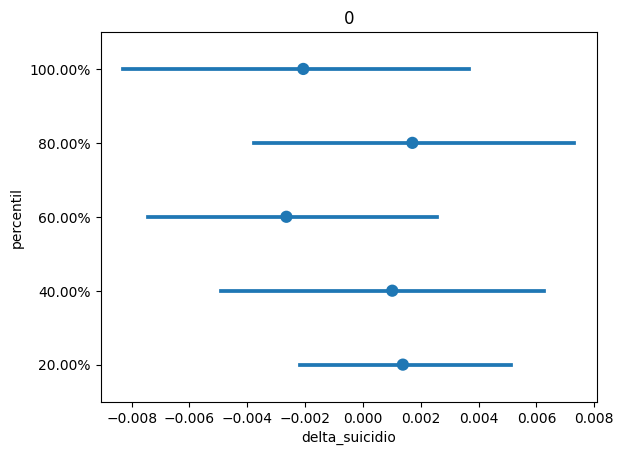

2020-02-01 00:00:00
2020-05-01 00:00:00
0.0014964801544786483
0.00016451852954576206
-0.0012039149684960684
-0.0027918160218040333
-0.0034739345048056154


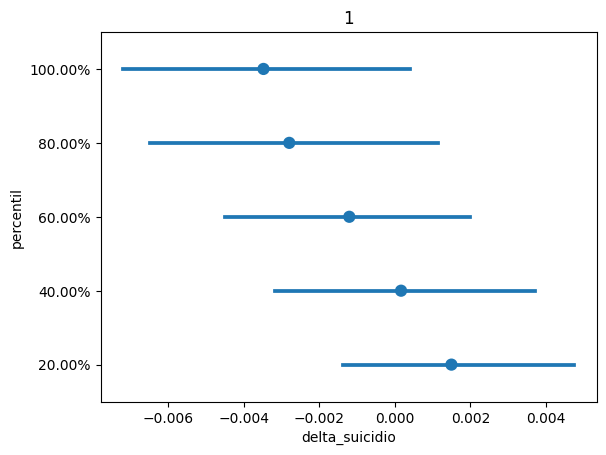

2019-12-01 00:00:00
2020-07-01 00:00:00
1.3182086668055149e-05
-0.0011734707297122067
-0.0027896149709427318
-0.0037947407321573135
-0.004781366167065218


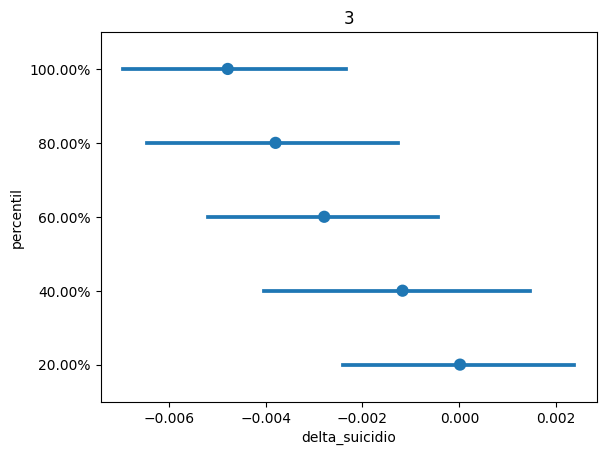

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.00013843265784554276
-0.0016791896784220297
-0.00047204558598950425
-0.003070843654866498
-0.0038756797037929527


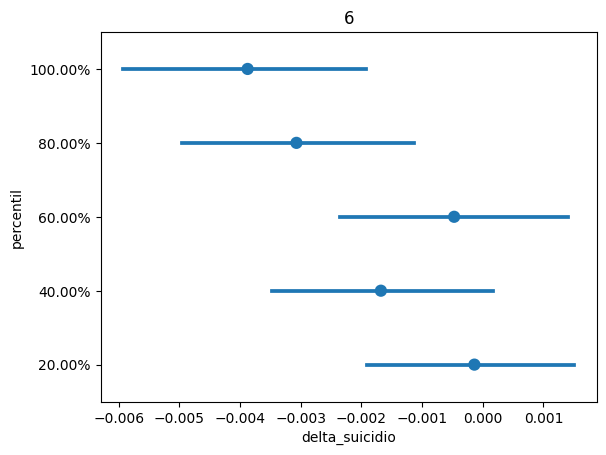

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.00043636024837962264
-0.0017486171207358268
-0.0009231508095835523
-0.002118816837609269
-0.0032894412243163456


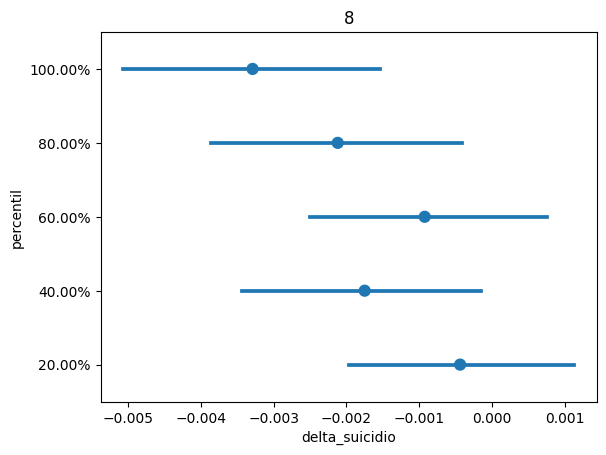

In [89]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_suicidio"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["valor_medio_y"] - df_antes_depois["valor_medio_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_suicidio"] = (
        df_antes_depois["taxa_suicidio_y"] - df_antes_depois["taxa_suicidio_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["taxa_suicidio_y"].mean()
            - df_percentil["taxa_suicidio_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_suicidio",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


2020-03-01 00:00:00
2020-04-01 00:00:00


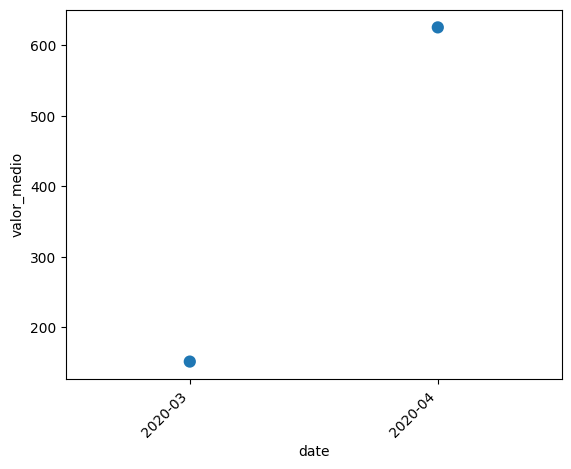

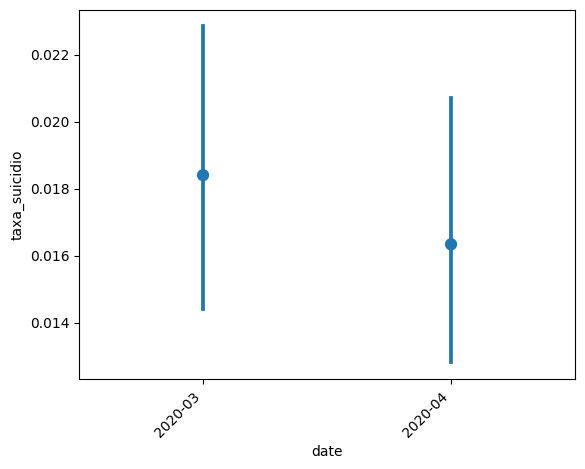

2020-02-01 00:00:00
2020-05-01 00:00:00


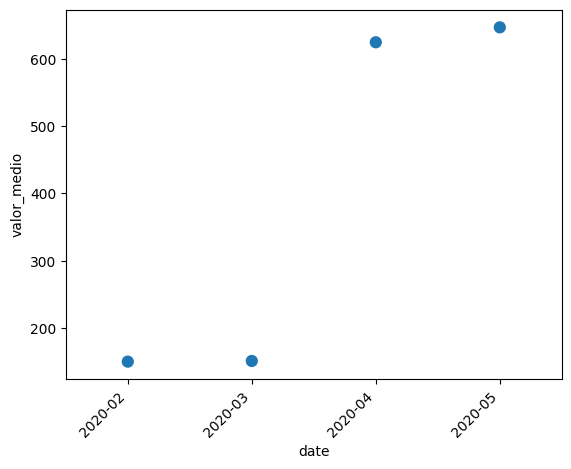

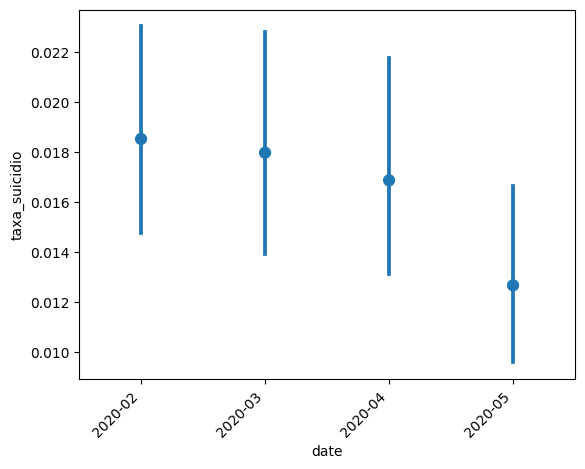

2019-12-01 00:00:00
2020-07-01 00:00:00


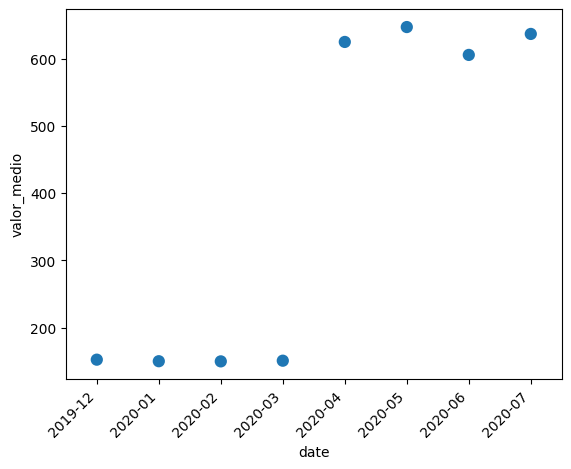

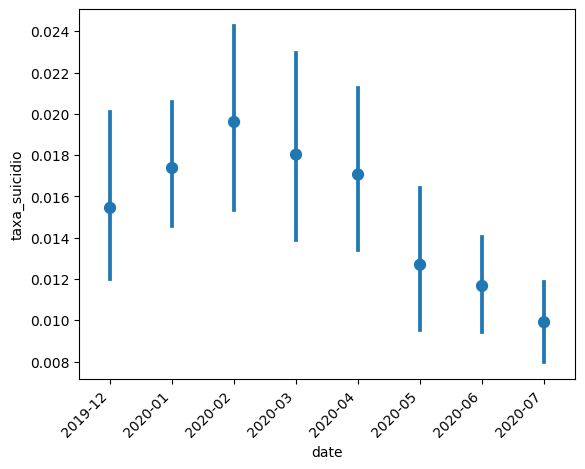

2019-09-01 00:00:00
2020-10-01 00:00:00


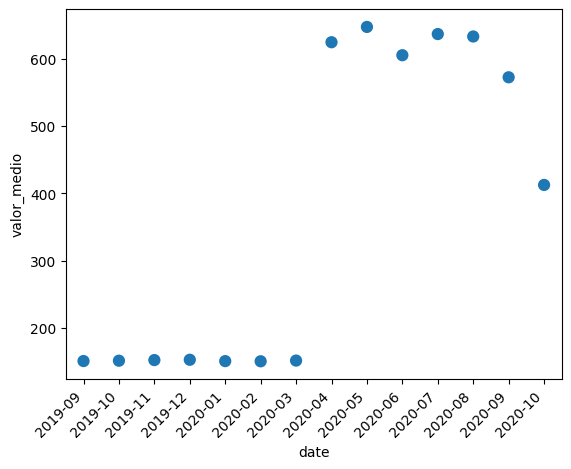

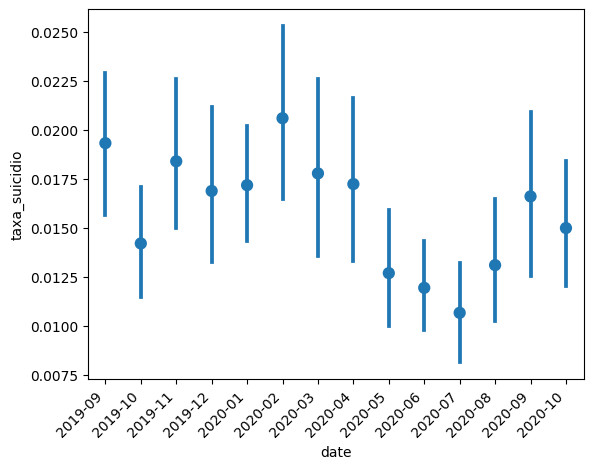

2019-07-01 00:00:00
2020-12-01 00:00:00


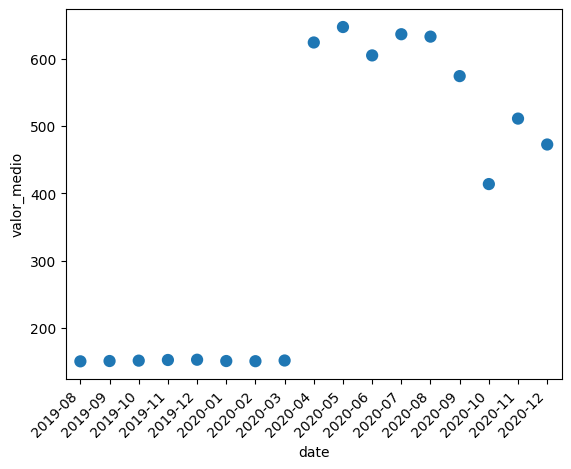

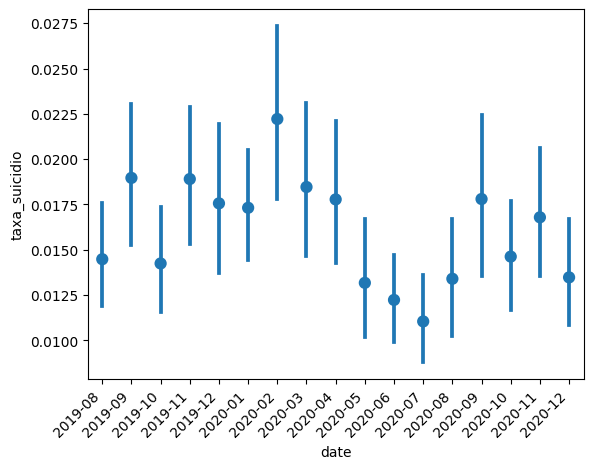

In [90]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_suicidio"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["valor_medio_y"] - df_antes_depois["valor_medio_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    maior_percentil = df_antes_depois[
        df_antes_depois["percentil"] == df_antes_depois["percentil"].max()
    ]["municipio_ibge"].unique()

    time_series_data = df_all[df_all["municipio_ibge"].isin(maior_percentil)]

    date_filter = (time_series_data["date"] >= start_date) & (
        time_series_data["date"] <= end_date
    )

    time_series_data = time_series_data[date_filter]

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="valor_medio",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    plt.show()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="taxa_suicidio",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    plt.show()


2020-03-01 00:00:00
2020-04-01 00:00:00


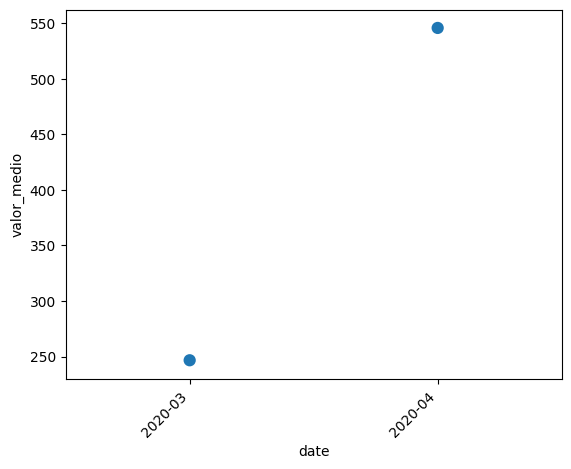

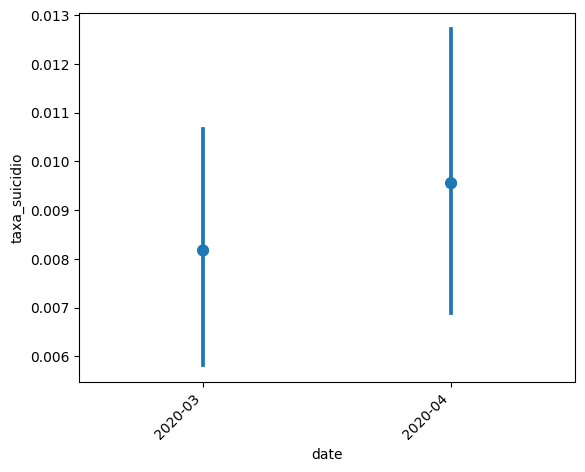

2020-02-01 00:00:00
2020-05-01 00:00:00


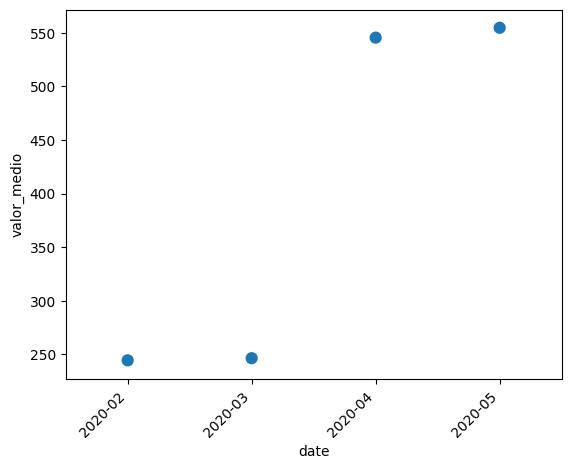

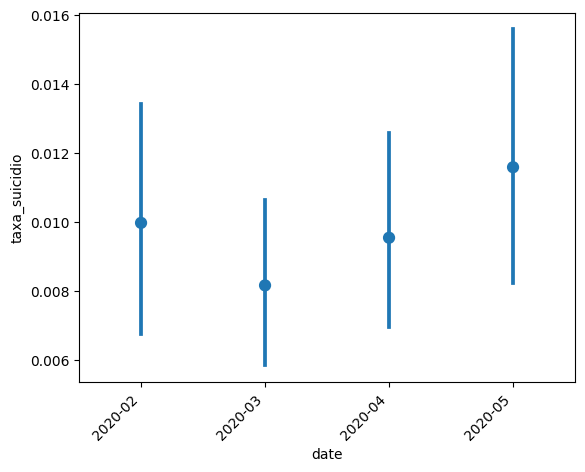

2019-12-01 00:00:00
2020-07-01 00:00:00


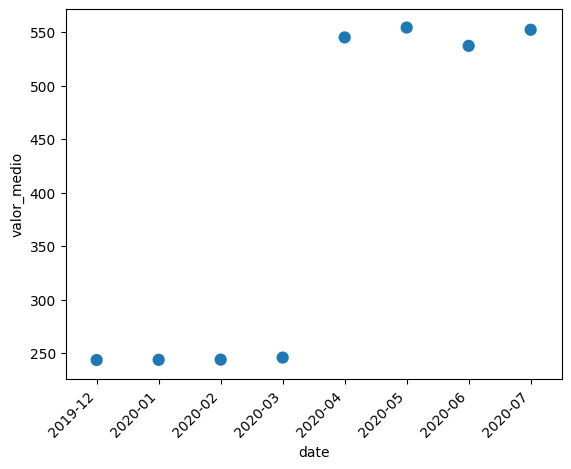

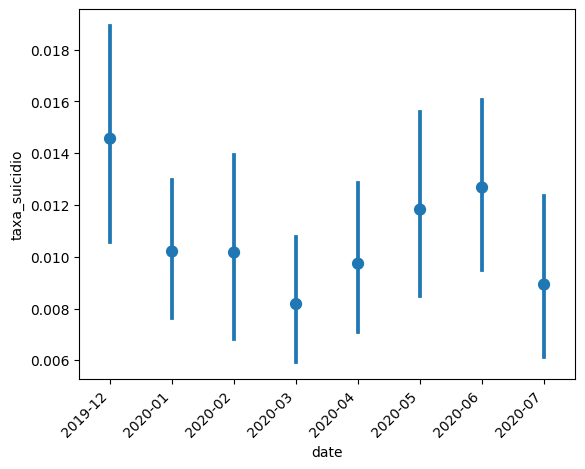

2019-09-01 00:00:00
2020-10-01 00:00:00


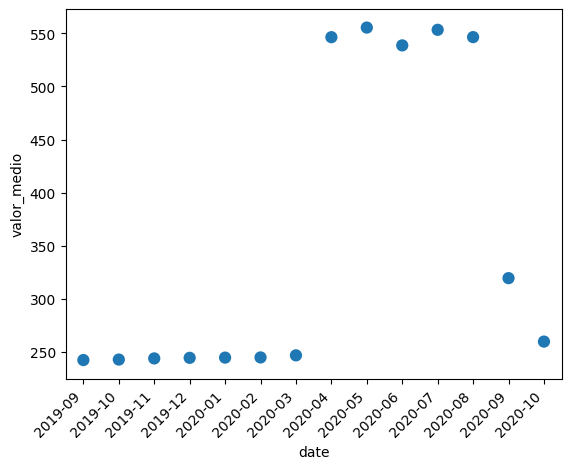

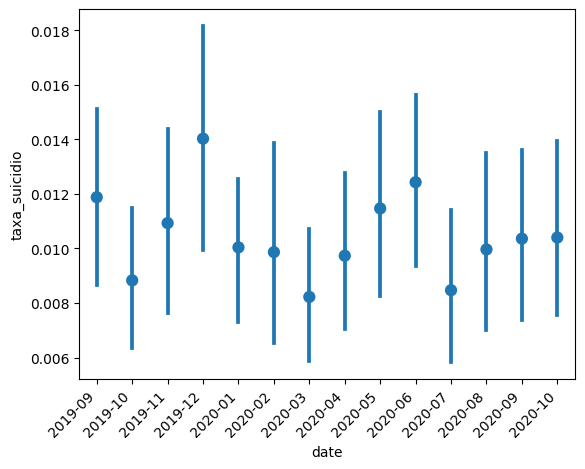

2019-07-01 00:00:00
2020-12-01 00:00:00


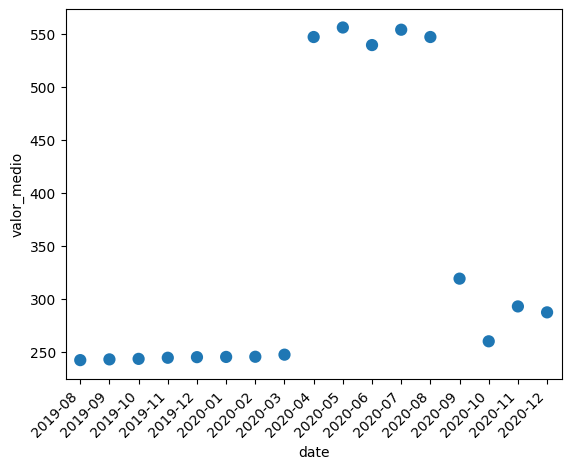

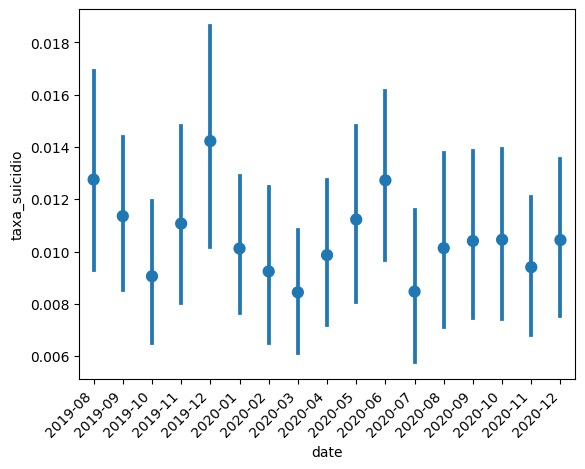

In [91]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_suicidio"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["valor_medio_y"] - df_antes_depois["valor_medio_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    menor_percentil = df_antes_depois[
        df_antes_depois["percentil"] == df_antes_depois["percentil"].min()
    ]["municipio_ibge"].unique()

    time_series_data = df_all[df_all["municipio_ibge"].isin(menor_percentil)]

    date_filter = (time_series_data["date"] >= start_date) & (
        time_series_data["date"] <= end_date
    )

    time_series_data = time_series_data[date_filter]

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="valor_medio",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    plt.show()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="taxa_suicidio",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    plt.show()


## Grau de cobertura


2020-03-01 00:00:00
2020-04-01 00:00:00
-0.001078608222751118
-0.005486424250248716
0.0012688471047222795
0.0028236726287937143
-0.0021886630238087228
-0.0006312646806348812
-0.0029521206923728022
-0.004726694619710006
-0.006081885923596634
-0.0012772399960948432
-0.00040747064320378976
0.007439123149212402
0.004061831430115818
0.0044417176695630166
0.00298706487952931


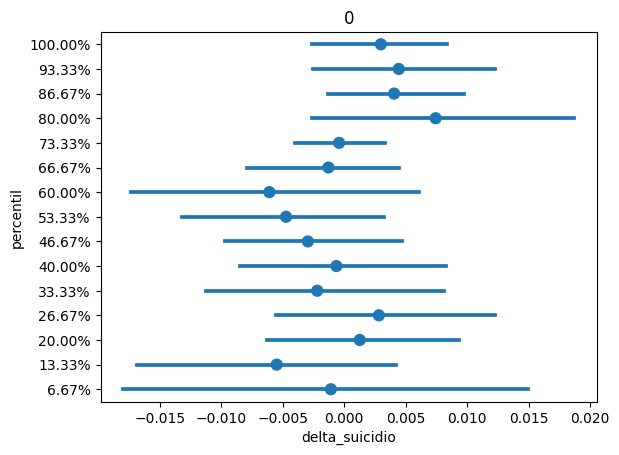

2020-02-01 00:00:00
2020-05-01 00:00:00
-0.005495474297650658
-0.005748810563183092
-0.0006110872471404832
-0.0032571470659112176
0.00038479506714960733
-0.002131793499290588
-0.0033276458816947213
-0.0035846209641557953
-0.0014079284805516793
-0.0018866077871326128
-0.00020441564557937934
0.0025590989267680504
0.003488261865432064
0.0021477837109066117
0.0016736320144925352


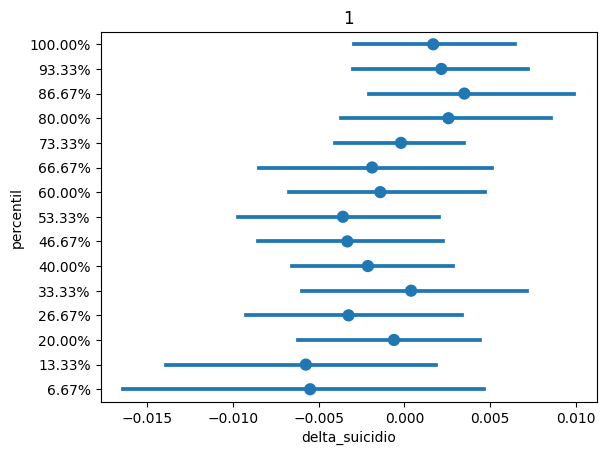

2019-12-01 00:00:00
2020-07-01 00:00:00
-0.0072766638132982925
-0.006069171470787473
0.000700930552956662
-0.00436595494282852
-0.0037905366340358713
-0.003956518431230871
-0.006945209977090678
0.0008063865665190479
-0.001712512268432836
-0.0032158920755067655
-0.0029945033786203112
0.0012163281750021595
-0.0015726117670530563
0.0018865762441124638
-0.00026637269724554165


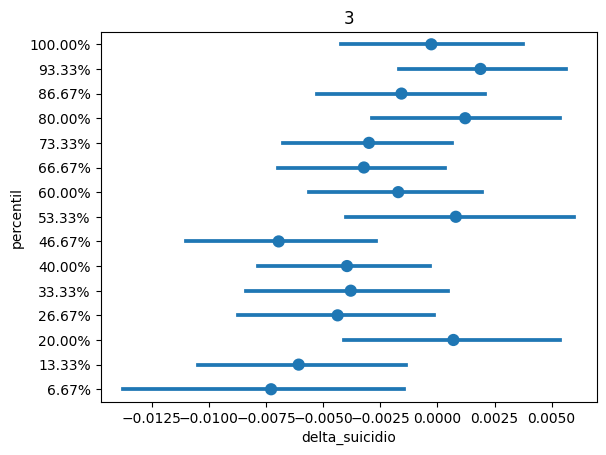

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.002712356995288521
-0.0016607810309504922
-0.002909950674474627
-0.003332396175065174
-0.0054364492631316964
-0.004086621626413987
-0.0031720028195498413
0.0008337097843800542
-0.0011562852893876804
-0.0012611796739677803
-0.00022194877197633835
-0.0029506074345625084
0.0005273674947712005
-0.000652494192650923
0.0005017941000685661


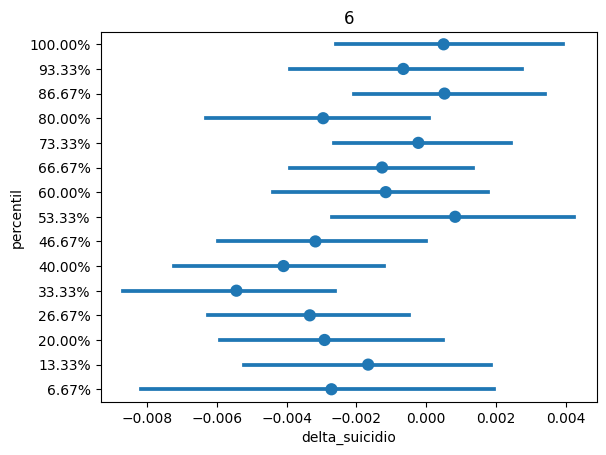

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.0016388977645465513
-0.0011343235974376198
-0.0031278273965217856
-0.002835063370791995
-0.005215039021244204
-0.0024669365438241345
-0.0018519917969930504
-0.0025728106521234317
-0.001305848906885669
-6.405052518174831e-06
-0.0004917565138586478
-0.0022226609698319
0.0009883697209713029
-0.0009939897639976193
-0.0006593281302489894


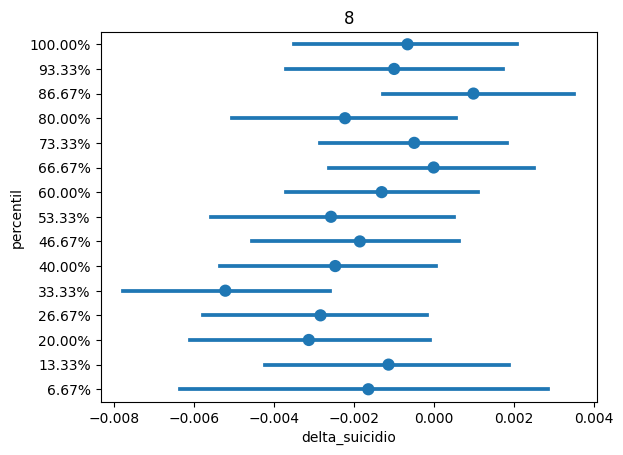

In [92]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_suicidio"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - 0

    divisao = 15
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_suicidio"] = (
        df_antes_depois["taxa_suicidio_y"] - df_antes_depois["taxa_suicidio_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["taxa_suicidio_y"].mean()
            - df_percentil["taxa_suicidio_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_suicidio",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


In [115]:
delta_meses = relativedelta(months=3)

mes_corte_1 = "2020-03-01"
mes_corte_2 = "2020-04-01"

start_date = pd.to_datetime(mes_corte_1) - delta_meses
end_date = pd.to_datetime(mes_corte_2) + delta_meses

print(start_date)
print(end_date)

df_antes = df_all[
    (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
]
df_depois = df_all[
    (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
]

colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_suicidio", "valor_medio"]

df_antes_mean = (
    df_antes.groupby("municipio_ibge")
    .mean()
    .reset_index()[colunas_relevantes]
)
df_depois_mean = (
    df_depois.groupby("municipio_ibge")
    .mean()
    .reset_index()[colunas_relevantes]
)

df_antes_depois = pd.merge(
    df_antes_mean, df_depois_mean, on=["municipio_ibge"]
)
df_antes_depois["variacao_cobertura"] = df_antes_depois["cobertura_ae_y"] - 0


divisao = 2
df_divisions = np.array_split(
    df_antes_depois.sort_values("variacao_cobertura"), divisao
)
for i, dfs_division in enumerate(df_divisions):
    indices = dfs_division.index
    df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
        1 / divisao
    )

df_antes_depois["delta_suicidio"] = (
    df_antes_depois["taxa_suicidio_y"] - df_antes_depois["taxa_suicidio_x"]
)

df_antes_depois["delta_valor"] = (
    df_antes_depois["valor_medio_y"] - df_antes_depois["valor_medio_x"]
)

df_antes_depois.groupby('percentil').mean()['delta_suicidio'][1] - df_antes_depois.groupby('percentil').mean()['delta_suicidio'][0.5]

2019-12-01 00:00:00
2020-07-01 00:00:00


0.003361187894838041

In [ ]:
ax = sns.pointplot(
    data=df_antes_depois,
    x="delta_suicidio",
    y="percentil",
    join=False,
    orient="h",
    order=-np.sort(-df_antes_depois["percentil"].unique()),
)
y_value = [
    "{:,.2f}".format(x * 100) + "%"
    for x in -np.sort(-df_antes_depois["percentil"].unique())
]
ax.set_yticklabels(y_value)
plt.title(n_meses)
plt.show()
